In [67]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import multivariate_normal
from scipy.ndimage import label

%matplotlib inline

In [68]:
# 1.1.1 Load first image of the video 

Im = cv2.imread("./cv23_lab2_material/part1 - GreekSignLanguage/1.png")
YCrCbIm = cv2.cvtColor(Im, cv2.COLOR_BGR2YCR_CB)

print("Image loaded as: ", type(YCrCbIm))

print("Resolution: ", YCrCbIm.shape)
print("Range: %d - %d " % (np.min(YCrCbIm), np.max(YCrCbIm)))

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350, 3)
Range: 2 - 240 


In [69]:
# Normalize to [0,1]
YCrCbIm = YCrCbIm.astype(float)/np.max(YCrCbIm)

print("Range: %f - %f " % (np.min(YCrCbIm), np.max(YCrCbIm)))

Range: 0.008333 - 1.000000 


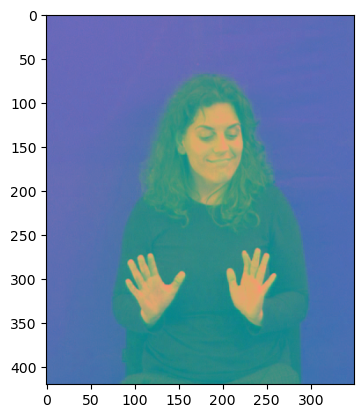

In [70]:
# Show image YCrCb colour space

plt.imshow(YCrCbIm)
plt.show()

In [71]:
# Load skin samples

mat = scipy.io.loadmat('./cv23_lab2_material/part1 - GreekSignLanguage/skinSamplesRGB.mat')
Skin_samples = mat['skinSamplesRGB']

YCrCb_Skin_samples = cv2.cvtColor(Skin_samples, cv2.COLOR_RGB2YCR_CB)

# Normalize to [0,1]
YCrCb_Skin_samples = YCrCb_Skin_samples.astype(float)/np.max(YCrCb_Skin_samples)

print(YCrCb_Skin_samples.shape)
print("Range: %f - %f " % (np.min(YCrCb_Skin_samples), np.max(YCrCb_Skin_samples)))

(22, 81, 3)
Range: 0.392562 - 1.000000 


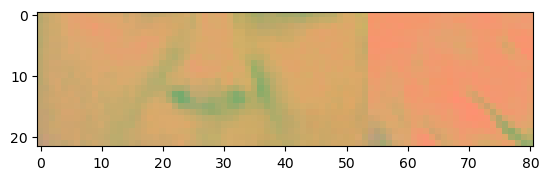

In [72]:
plt.imshow(YCrCb_Skin_samples)
plt.show()

In [73]:
# Estimate 2D-Gaussian according to CrCb samples

CrCb_Skin_samples = YCrCb_Skin_samples[:,:,1:].reshape((22*81,2))

print(CrCb_Skin_samples.shape)

# Maximum Likelihood estimation

mean_ML = np.sum(CrCb_Skin_samples, axis=0)/CrCb_Skin_samples.shape[0]
print(mean_ML)

Std_ML = np.matmul((CrCb_Skin_samples - mean_ML).T,(CrCb_Skin_samples - mean_ML))/CrCb_Skin_samples.shape[0]
print(Std_ML)


(1782, 2)
[0.64895048 0.42673753]
[[ 0.00075415 -0.00020361]
 [-0.00020361  0.00019106]]


In [74]:
def fd(CrCbIm, mean, Std):
    gauss2D = multivariate_normal(mean,Std)
    Skin = (gauss2D.pdf(CrCbIm) > 0.25).astype('uint8')
    
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_big = np.ones((13, 13), np.uint8)
    
    Skin = cv2.morphologyEx(Skin, cv2.MORPH_OPEN, kernel_small, iterations=1) # Opening
    
    Skin = cv2.morphologyEx(Skin, cv2.MORPH_CLOSE, kernel_big, iterations=1) # Closing
    
    Skin, num_features = label(Skin)
    
    plt.imshow(Skin)
    plt.show()
    
    Bounding_Boxes = []
    for i in range(1,num_features + 1):
        Bounding_Box = []
        Area = (Skin == i)
        Indeces = np.nonzero(Area)
        Bounding_Box.append(min(Indeces[1]))
        Bounding_Box.append(min(Indeces[0]))
        Bounding_Box.append(max(Indeces[1]) - min(Indeces[1]))
        Bounding_Box.append(max(Indeces[0]) - min(Indeces[0]))
        Bounding_Boxes.append(Bounding_Box)
        
    return Bounding_Boxes
    

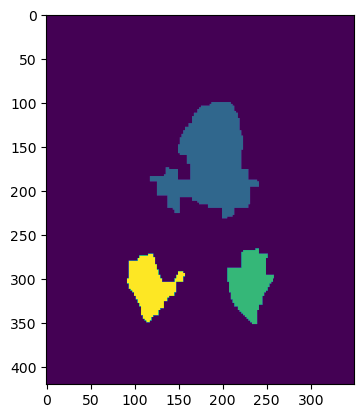

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[118, 100, 123, 131], [206, 266, 52, 85], [92, 272, 65, 77]]
(420, 350, 3)


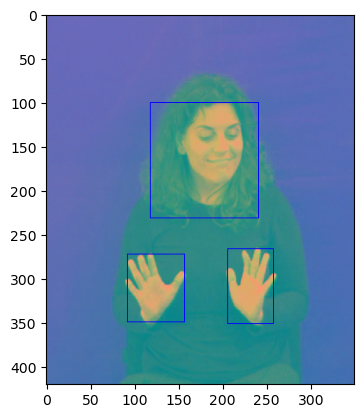

In [75]:
Bounding_Boxes = fd(YCrCbIm[:,:,1:],mean_ML,Std_ML)

print(Bounding_Boxes)

for Bounding_Box in Bounding_Boxes:
    x = Bounding_Box[0]
    y = Bounding_Box[1]
    w = Bounding_Box[2]
    h = Bounding_Box[3]
    YCrCbIm = cv2.rectangle(YCrCbIm, (x,y), (x+w,y+h), (0,0,255), 1)
    
print(YCrCbIm.shape)
    
# Displaying the image 
plt.imshow(YCrCbIm)
plt.show()